# My 1st Kaggle Competition - House Prices Advanced Regression Techniques

## COMPETITION DESCRIPTION
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

GOAL
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

METRIC
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## SOLUTION

### FRAME THE PROBLEM
It is clearly a typical supervised learning task since we are given labeled training examples. Moreover, it is also a typical regression task, since we are asked to predict a value. More specifically, this is a multivariate regression problem since the system will use multiple features to make a prediction. Finally, there is no continuous flow of data coming in the system so there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.

### GET THE DATA

In [1]:
import pandas as pd
housing_train = pd.read_csv('Train.csv')
housing_test = pd.read_csv('test.csv')

Let's take a quick look at the data structure

In [2]:
housing_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Each row represents one observation. There are 80 attributes plus the Id column.

The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute's type and number of non-null values.

In [3]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

There are 1460 instances in the train dataset, which means that is fairly small by Machine Learning standards, but it's ok to get  started and make some predictions. Notice that we have some attributes with missing values, such as PoolQC, Fence, MiscFeature.... We will need to take care of this later.

### DATA CLEANING

We want to develop a model that is both accurate — it can predict the 'Sale Price' close to the true value — and interpretable — we can understand the model predictions. Once we know the goal, we can use it to guide our decisions as we dig into the data and build models. As we also want to focus on interpretability it is important to understand at least some of the columns. In the 'data_description.txt' file provided by Kaggle there is a description of each feature and their possible values.

Before dealing wth the missing values we should concatenate the train and test data in the same dataframe.

In [4]:
nhousing_train = housing_train.shape[0]
nhousing_test = housing_test.shape[0]
y_train = housing_train['SalePrice'].values
test_ID = housing_test['Id'].values
all_data = pd.concat((housing_train,housing_test),axis=0).reset_index(drop=True)
all_data.drop(['Id','SalePrice'],axis=1,inplace=True)
print('all_data size is: {}'.format(all_data.shape))

all_data size is: (2919, 79)


#### Looking for missing values

Let's plot a heatmap to see the missing data of our complete dataset (train + test):

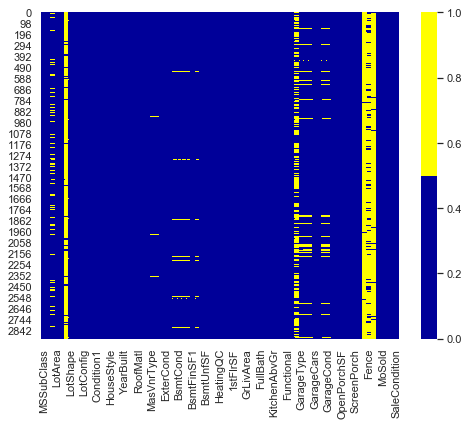

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

cols = all_data.columns
colours = ['#000099', '#ffff00']
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(all_data[cols].isnull(), cmap=sns.color_palette(colours))

In the case of having so many features in the dataset we can make a list of missing data % for each feature:

In [6]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na_values = all_data.isnull().sum()
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
all_data_na_values = all_data_na_values.drop(all_data_na_values[all_data_na_values == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Nº Missing Values':all_data_na_values,'Missing Ratio' :all_data_na})
print(missing_data)

              Nº Missing Values  Missing Ratio
PoolQC                     2909      99.657417
MiscFeature                2814      96.402878
Alley                      2721      93.216855
Fence                      2348      80.438506
FireplaceQu                1420      48.646797
LotFrontage                 486      16.649538
GarageFinish                159       5.447071
GarageYrBlt                 159       5.447071
GarageQual                  159       5.447071
GarageCond                  159       5.447071
GarageType                  157       5.378554
BsmtExposure                 82       2.809181
BsmtCond                     82       2.809181
BsmtQual                     81       2.774923
BsmtFinType2                 80       2.740665
BsmtFinType1                 79       2.706406
MasVnrType                   24       0.822199
MasVnrArea                   23       0.787941
MSZoning                      4       0.137033
BsmtFullBath                  2       0.068517
BsmtHalfBath 

If plot an histogram:

Text(0.5, 1.0, 'Percent missing data by feature')

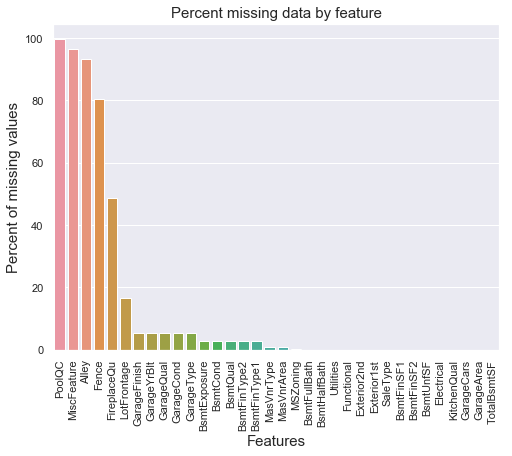

In [7]:
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

An histogram is a good choice when we have many features. To learn more about the missing value patterns among observations, we can visualize it by a histogram.

Text(0.5, 1.0, 'Nº of observations with missing values')

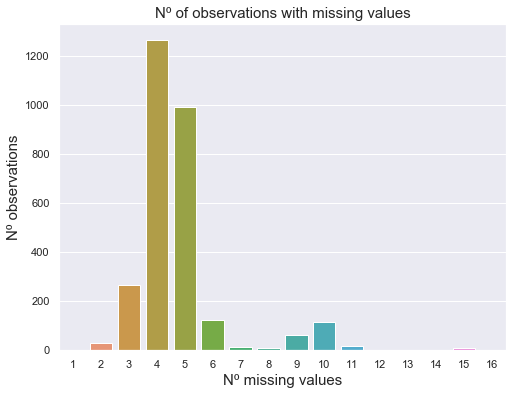

In [8]:
missing_values_obs = pd.DataFrame(all_data.isnull().sum(axis=1).value_counts())
missing_values_obs.reset_index(inplace=True)
missing_values_obs.rename(columns={'index':'Nº missing values',0:'Nº observations'},inplace=True)
missing_values_obs.sort_values('Nº missing values',axis=0,ascending=True,inplace=True)
missing_values_obs

f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=missing_values_obs['Nº missing values'], y=missing_values_obs['Nº observations'])
plt.xlabel('Nº missing values', fontsize=15)
plt.ylabel('Nº observations', fontsize=15)
plt.title('Nº of observations with missing values', fontsize=15)

This histogram helps to identify the missing values situations among the 2919 observations. For example, there are around 1200 observations with 4 missing values. Notice that there is no observation with all of the values.

#### Dealing with duplicated data

Now we will check if there is any observation with repeated values.

In [9]:
all_data[all_data.duplicated(keep=False)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
193,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
829,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
2713,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
2865,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


As we can see there are two pair of observations with identical attributes. Each pair of observations has one belonging to the training dataset (rows 193 and 829) and the other belonging to the test dataset (rows 2713 and 2865). We are going to delete the ones corresponding to the training dataset because it doesn't make sense to test our model with the observations that has been trained.

In [10]:
import numpy as np

all_data.drop([193,829],axis=0,inplace=True)
y_train = np.delete(y_train,193)
y_train = np.delete(y_train,829)
all_data.reset_index(inplace=True)

#### Imputing missing values

It's time to impute the missing values. We impute them by proceeding sequentially through features with missing values:

- PoolQC: data description says NA means "No Pool"

In [11]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- MiscFeature: data description says NA means "no misc feature"

In [12]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- Alley: data description says NA means "no alley access"

In [13]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- Fence: data description says NA means "no fence"

In [14]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- FireplaceQu: data description says NA means "no fireplace"

In [15]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage: Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [16]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond: Replacing missing data with None

In [17]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- GarageYrBlt, GarageArea and GarageCars: Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [18]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: missing values are likely zero for having no basement

In [19]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2: For all these categorical basement-related features, NaN means that there is no basement.

In [20]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('NoBsmt')

- MasVnrArea and MasVnrType: NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [21]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning (The general zoning classification): 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [22]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities: For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [23]:
all_data = all_data.drop(['Utilities'], axis=1)

- Functional: data description says NA means typical

In [24]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- Electrical: It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [25]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [26]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- Exterior1st and Exterior2nd: Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [27]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- SaleType: Fill in again with most frequent which is "WD"

In [28]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- MSSubClass: Na most likely means No building class. We can replace missing values with None

In [29]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Let's check if there is any remaining missing value:

In [30]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na_values = all_data.isnull().sum()
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
all_data_na_values = all_data_na_values.drop(all_data_na_values[all_data_na_values == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Nº Missing Values':all_data_na_values,'Missing Ratio' :all_data_na})
print(missing_data)

Empty DataFrame
Columns: [Nº Missing Values, Missing Ratio]
Index: []


### EXPLORATORY DATA ANALYSIS

The purpose is to to find anomalies, patterns, trends, or relationships. These may be interesting by themselves (for example finding a correlation between two variables) or they can be used to inform modeling decisions such as which features to use. In short, the goal of EDA is to determine what our data can tell us! EDA generally starts out with a high-level overview, and then narrows in to specific parts of the dataset once as we find interesting areas to examine.

To begin the EDA, we will focus on a single variable, the SalePrice, because this is the target for our machine learning models.

First of all we need to get back to our train and test sets.

In [31]:
nhousing_train = all_data.shape[0]-nhousing_test #Remember we removed two observations from the train set, so we need to update the length
housing_train = all_data[:nhousing_train]
housing_test = all_data[nhousing_train:]
housing_train['SalePrice'] = y_train #We have to add the SalePrice column removed before

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Analysing 'SalePrice'

We'll plot the probability distribution of our target variable.


 mu = 180966.36 and sigma = 79457.58



Text(0.5, 1.0, 'SalePrice distribution')

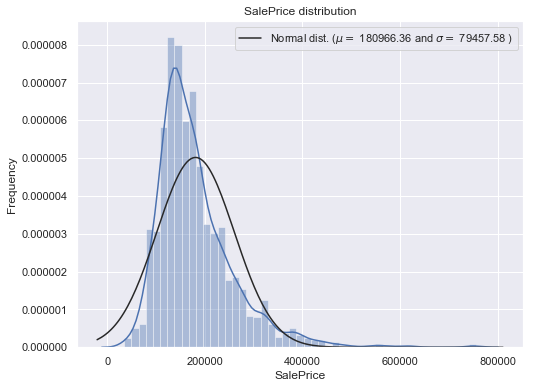

In [32]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(housing_train['SalePrice'],fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(housing_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

We can see that the distribution:

- Is devated from the normal distribution.
- Has positive skewness.
- Shows peakedness.

Let's now analyse the relationship between 'SalePrice' and other variables that seeem to play an important role in this problem:

- OverallQual.
- YearBuilt.
- TotalBsmtSF.
- GrLivArea.

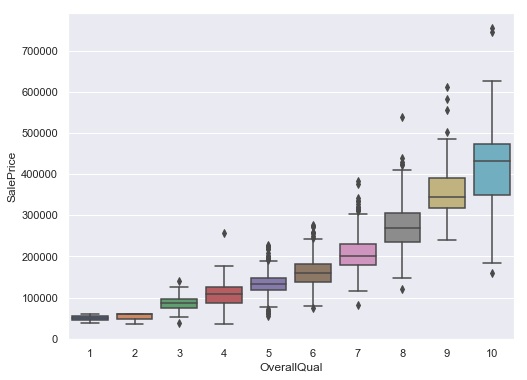

In [33]:
f, ax = plt.subplots(figsize=(8,6))
sns.boxplot(housing_train['OverallQual'],housing_train['SalePrice'])

As we expected, 'OverallQual' has a strong relationship with 'SalePrice'

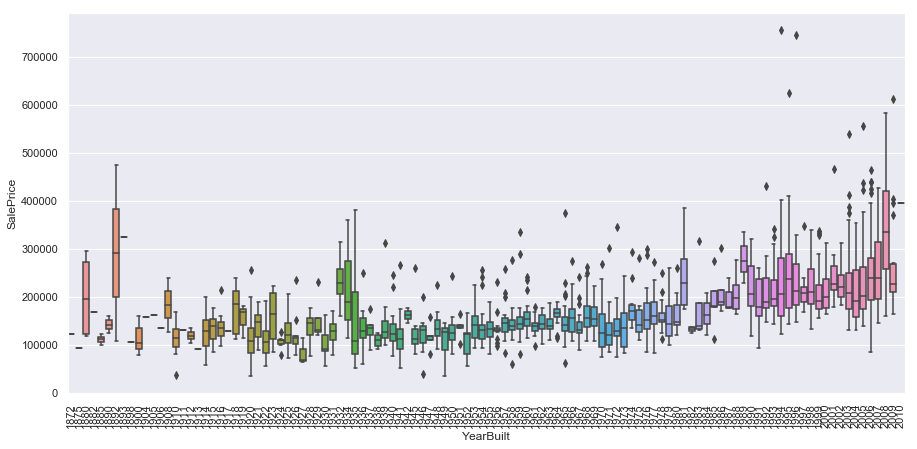

In [34]:
f, ax = plt.subplots(figsize=(15,7))
sns.boxplot(housing_train['YearBuilt'],housing_train['SalePrice'])
plt.xticks(rotation=90);

It's not a strong tendency, but We'd say that the price of a house is higher if it's a new one.

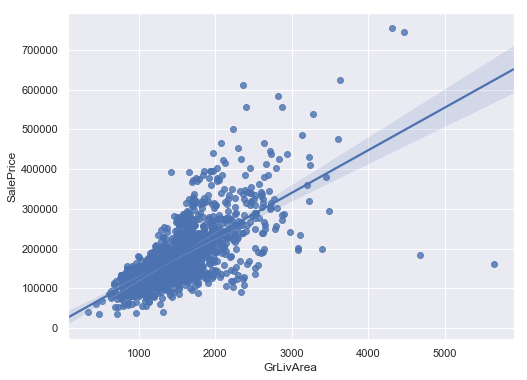

In [35]:
f, ax = plt.subplots(figsize=(8,6))
sns.regplot(housing_train['GrLivArea'],housing_train['SalePrice'],housing_train)

It seems that 'SalePrice' and 'GrLivArea' have a linear relationship. It also seems like we have some outliers when GrLivArea > 4500...Let's now see 'TotalBsmtSF'.

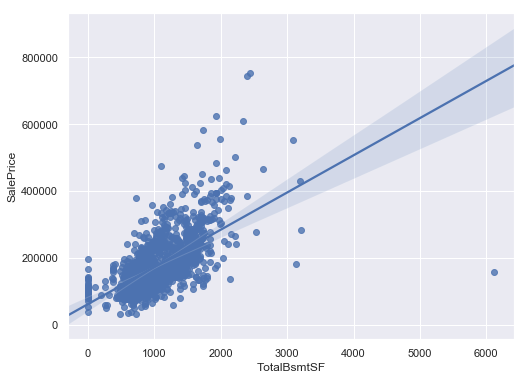

In [36]:
f, ax = plt.subplots(figsize=(8,6))
sns.regplot(housing_train['TotalBsmtSF'],housing_train['SalePrice'],housing_train)

As before, it looks like we have one outlier when TotalBsmtSF > 600...Let's see if it has any relationship with the ouliers of GrLivArea.

In [37]:
housing_train[housing_train['TotalBsmtSF']>6000]['GrLivArea']

1296    5642
Name: GrLivArea, dtype: int64

Yes! both values correspond to the same observation, so it seems that we are in front of an outlier.

### Dealing with Outliers

When we remove outliers, we want to be careful that we are not throwing away measurements just because they look strange. They may be the result of actual phenomenon that we should further investigate. When removing outliers, I try to be as conservative as possible, using the definition of an extreme outlier:

- On the low end, an extreme outlier is below $\text{First Quartile} -3 * \text{Interquartile Range}$
- On the high end, an extreme outlier is above $\text{Third Quartile} + 3 * \text{Interquartile Range}$

In this case, We will only remove the single outlying point and see how the distribution looks.

In [38]:
# Calculate first and third quartile
first_quartile = housing_train['GrLivArea'].describe()['25%']
third_quartile = housing_train['GrLivArea'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
housing_train = housing_train[(housing_train['GrLivArea'] > (first_quartile - 3 * iqr)) &
            (housing_train['GrLivArea'] < (third_quartile + 3 * iqr))]

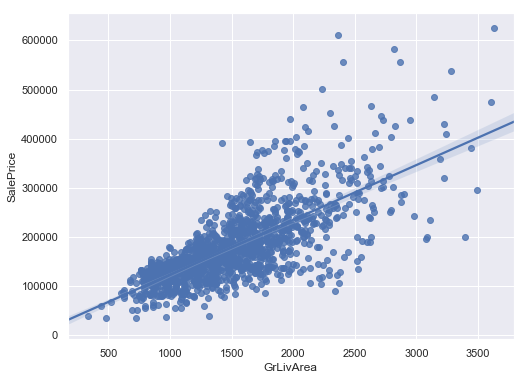

In [39]:
f, ax = plt.subplots(figsize=(8,6))
sns.regplot(housing_train['GrLivArea'],housing_train['SalePrice'],housing_train)

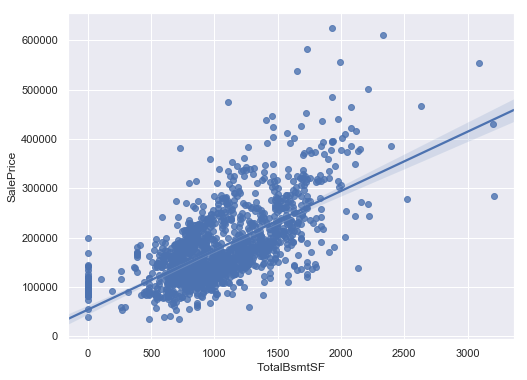

In [40]:
f, ax = plt.subplots(figsize=(8,6))
sns.regplot(housing_train['TotalBsmtSF'],housing_train['SalePrice'],housing_train)


 mu = 180195.46 and sigma = 76710.78



Text(0.5, 1.0, 'SalePrice distribution')

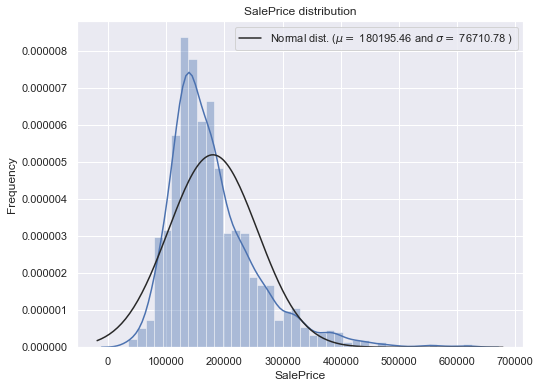

In [41]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(housing_train['SalePrice'],fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(housing_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

After removing the outliers, we can get back to the analysis.

This plot looks a little less suspicious and is close to normally distributed with a long tail on the right side (it has a positive skew).

### Correlations between Features and Target

In order to quantify correlations between the features (variables) and the target, we can calculate the Pearson correlation coefficient. Although there can be non-linear relationships between the features and targets and correlation coefficients do not account for interactions between features, linear relationships are a good way to start exploring trends in the data. We can then use these values for selecting the features to employ in our model.

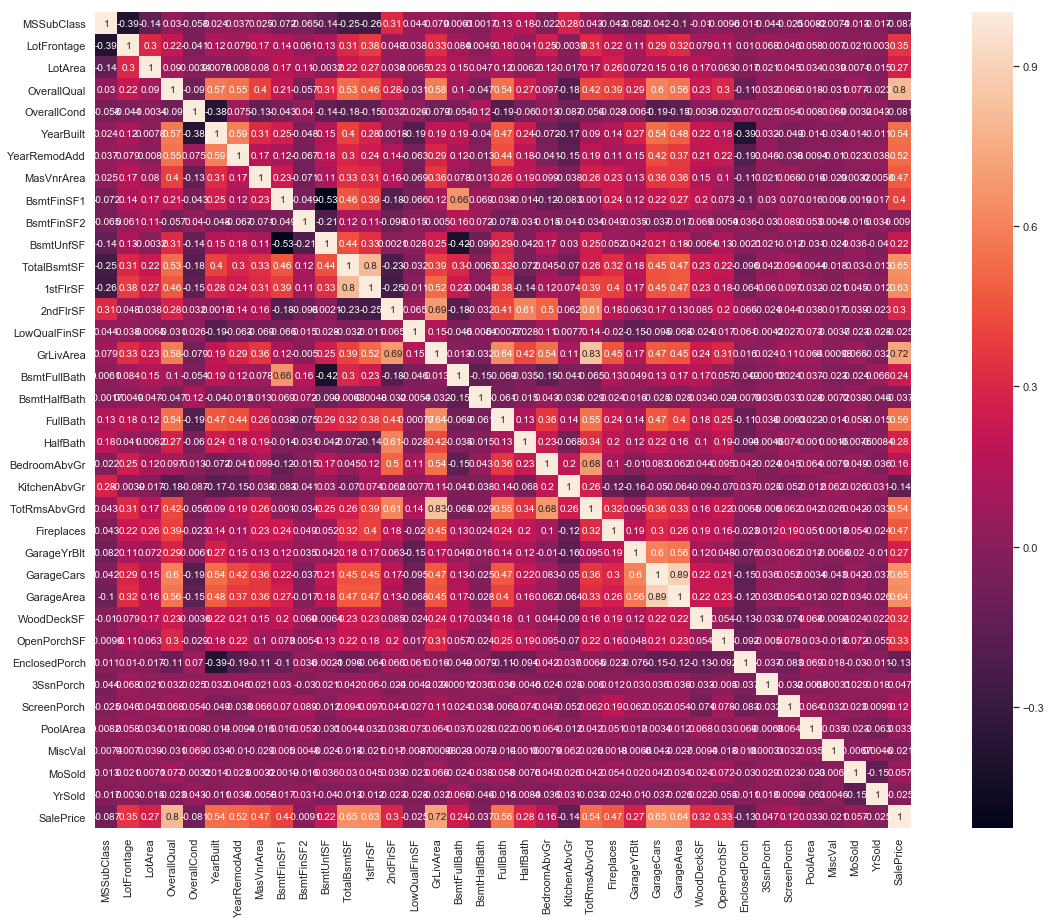

In [42]:
#Correlation map to see how features are correlated with SalePrice
corrmat = housing_train.iloc[:,1:].corr()
plt.subplots(figsize=(22,15))
sns.heatmap(corrmat, square=True,annot=True)

In [43]:
num_feat = housing_train.select_dtypes(include='number').columns
for i in num_feat:
    if abs(housing_train[i].corr(housing_train['SalePrice'])) > 0.2:
        print(i, '-', 'SalesPrice:', housing_train[i].corr(housing_train['SalePrice']))

LotFrontage - SalesPrice: 0.35179248207008007
LotArea - SalesPrice: 0.2694070555493969
OverallQual - SalesPrice: 0.8017356395970658
YearBuilt - SalesPrice: 0.5367103855338683
YearRemodAdd - SalesPrice: 0.5227674232520776
MasVnrArea - SalesPrice: 0.4732246018162386
BsmtFinSF1 - SalesPrice: 0.39527763274551775
BsmtUnfSF - SalesPrice: 0.22128952607735733
TotalBsmtSF - SalesPrice: 0.6464141051951094
1stFlrSF - SalesPrice: 0.6251886648090217
2ndFlrSF - SalesPrice: 0.2982131188001122
GrLivArea - SalesPrice: 0.7208066268937775
BsmtFullBath - SalesPrice: 0.23504792361679805
FullBath - SalesPrice: 0.5601499671414952
HalfBath - SalesPrice: 0.2829887562320479
TotRmsAbvGrd - SalesPrice: 0.5377448059638291
Fireplaces - SalesPrice: 0.46606013642254773
GarageYrBlt - SalesPrice: 0.26858149237088147
GarageCars - SalesPrice: 0.6495862064903882
GarageArea - SalesPrice: 0.6369340091111063
WoodDeckSF - SalesPrice: 0.32228117327908606
OpenPorchSF - SalesPrice: 0.33141110524221046
SalePrice - SalesPrice: 1.0

This heatmap is the best way to get a quick overview of our variables and its relationships.

At first sight, there are two red colored squares that get my attention. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'GarageX' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. Heatmaps are great to detect this kind of situations and in problems dominated by feature selection, like ours, they are an essential tool.

Another thing that got my attention was the 'SalePrice' correlations. We can see our well-known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' saying a big 'Hi!', but we can also see many other variables that should be taken into account.

### Non-linear Relationships

To account for possible non-linear relationships, we can take square root and natural log transformations of the features and then calculate the correlation coefficients with the SalePrice. To try and capture any possible relationships between the categorical variables and the SalePrice we will have to one-hot encode these columns.

In the following code, we take log and square root transformations of the numerical variables, one-hot encode the categorical variables, calculate the correlations between all of the features and the SalePrice, and display the top 15 most positive and top 15 most negative correlations.

In [44]:
# Select the numeric columns
numeric_subset = housing_train.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the SalePrice column
    if col == 'SalePrice':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col]+1)

# Select the categorical columns
categorical_subset = housing_train.select_dtypes(exclude='number')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()['SalePrice'].sort_values()

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [45]:
# Display most negative correlations
correlations.head(15)

ExterQual_TA        -0.601320
KitchenQual_TA      -0.530613
FireplaceQu_None    -0.480049
BsmtQual_TA         -0.461926
GarageFinish_Unf    -0.417784
MasVnrType_None     -0.380306
GarageType_Detchd   -0.360871
Foundation_CBlock   -0.348680
HeatingQC_TA        -0.318901
MSZoning_RM         -0.294267
LotShape_Reg        -0.264406
BsmtExposure_No     -0.260015
CentralAir_N        -0.258261
SaleType_WD         -0.256994
GarageQual_None     -0.243419
Name: SalePrice, dtype: float64

In [46]:
# Display most positive correlations
correlations.tail(15)

sqrt_TotalBsmtSF    0.564054
log_GarageCars      0.586417
log_1stFlrSF        0.598089
sqrt_1stFlrSF       0.614861
1stFlrSF            0.625189
GarageArea          0.636934
TotalBsmtSF         0.646414
GarageCars          0.649586
log_GrLivArea       0.700344
sqrt_GrLivArea      0.715022
GrLivArea           0.720807
log_OverallQual     0.758469
sqrt_OverallQual    0.778956
OverallQual         0.801736
SalePrice           1.000000
Name: SalePrice, dtype: float64

After transforming the features, the strongest relationships are still those related to OverallQual and GrLivArea. The log and square root transformations do not seem the have resulted in any stronger relationships. Related to negative linear relationships we can see that the top 15 are one-hot encoded representation of the categorical variables.

We can use these correlations in order to perform feature selection (coming up in a little bit).

### Feature Engineering and Selection

Now that we have explored the trends and relationships within the data, we can work on engineering a set of features for our models. We can use the results of the EDA to inform this feature engineering. In particular, we learned the following from EDA which can help us in engineering/selecting features:

- Taking the log transformation of features does not result in significant increases in the linear correlations between features and the score.

Before we get any further, we should define what feature engineering and selection are! These definitions are informal and have considerable overlap, but I like to think of them as two separate processes:

- Feature Engineering: The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables, such as we did with the log and square root, or one-hot encoding categorical variables so they can be used in a model. Generally, I think of feature engineering as adding additional features derived from the raw data.
- Feature Selection: The process of choosing the most relevant features in your data. "Most relevant" can depend on many factors, but it might be something as simple as the highest correlation with the target, or the features with the most variance. In feature selection, we remove features that do not help our model learn the relationship between features and the target. This can help the model generalize better to new data and results in a more interpretable model. Generally, I think of feature selection as subtracting features so we are left with only those that are most important.

Feature engineering and selection are iterative processes that will usually require several attempts to get right. Often we will use the results of modeling, such as the feature importances from a random forest, to go back and redo feature selection, or we might later discover relationships that necessitate creating new variables. Moreover, these processes usually incorporate a mixture of domain knowledge and statistical qualitites of the data.

#### A little bit of feature engineering

Some numerical features of our problem are actually really categories, such as MSSubClass, YrSold and MoSold, so we can convert them to categorical.

We have to apply the feature engineering to all of our data (train and test).

In [47]:
nhousing_train = housing_train.shape[0]
nhousing_test = housing_test.shape[0]
y_train = housing_train['SalePrice'].values
all_data = pd.concat((housing_train,housing_test),axis=0).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)

In [48]:
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"},
                             'YrSold' : {2006 : '2006', 2007 : '2007', 2008 : '2008', 2009 : '2009', 2010 : '2010'}
                      })

As well, some categorical features can be defined as numerical if there is information in the order, so we can encode them.

In [49]:
all_data = all_data.replace({"Alley" : {'None' : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"NoBsmt" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {'NoBsmt' : 0, "No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4},
                       "BsmtFinType1" : {"NoBsmt" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"NoBsmt" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"NoBsmt" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2}})

In [50]:
all_data['BsmtCond'] = pd.to_numeric(all_data['BsmtCond'])

Now we can create some new features, by for example combining existing features.

In [51]:
# Overall quality of the house
all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]
# Overall quality of the garage
all_data["GarageGrade"] = all_data["GarageQual"] * all_data["GarageCond"]
# Overall quality of the exterior
all_data["ExterGrade"] = all_data["ExterQual"] * all_data["ExterCond"]
# Overall kitchen score
all_data["KitchenScore"] = all_data["KitchenAbvGr"] * all_data["KitchenQual"]
# Overall fireplace score
all_data["FireplaceScore"] = all_data["Fireplaces"] * all_data["FireplaceQu"]
# Overall garage score
all_data["GarageScore"] = all_data["GarageArea"] * all_data["GarageQual"]
# Overall pool score
all_data["PoolScore"] = all_data["PoolArea"] * all_data["PoolQC"]

# Total number of bathrooms
all_data["TotalBath"] = all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"]) + all_data["FullBath"] + (0.5 * all_data["HalfBath"])
# Total SF for house (incl. basement)
all_data["AllSF"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
all_data["AllFlrsSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# Total SF for porch
all_data["AllPorchSF"] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + all_data["3SsnPorch"] + all_data["ScreenPorch"]
# Has masonry veneer or not
all_data["HasMasVnr"] = all_data.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
all_data["BoughtOffPlan"] = all_data.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

Adding transformed features can help our model learn non-linear relationships within the data. Taking the square root, natural log, or various powers of features is common practice in data science and can be based on domain knowledge or what works best in practice. Here we will include the square root, natural log and power of 2 and 3 of all numerical features.

In [52]:
numerical_features = all_data.select_dtypes('number')
categorical_features = all_data.select_dtypes(exclude='number')
numerical_features.drop(['index'],axis=1,inplace=True)
for col in numerical_features.columns:
    numerical_features['sqrt_'+col] = np.sqrt(numerical_features[col])
    numerical_features['log_'+col] = np.log(numerical_features[col]+1)
    numerical_features['s2_'+col] = numerical_features[col]**2
    numerical_features['s3_'+col] = numerical_features[col]**3

all_data = pd.concat([categorical_features,numerical_features],axis=1)

C:\Users\usuario\Anaconda3\lib\site-packages\pandas\core\frame.py:3982: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

We're going to One-hot encode the rest of categorical variables, as there is no information in the order.

In [53]:
categorical_features = all_data.select_dtypes(exclude='number').columns
all_data_cat = all_data[categorical_features]
all_data_cat_dumm = pd.get_dummies(all_data_cat)
all_data_cat_dumm.shape
all_data = pd.concat([all_data,all_data_cat_dumm],axis=1)
all_data.drop(categorical_features,axis=1,inplace=True)
all_data.head()

,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2,0,4,3,7,5,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,2,0,4,3,6,8,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2,0,3,3,7,5,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,2,0,3,3,7,5,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2,0,3,3,8,5,2000,2000,...,0,0,0,1,0,0,0,0,1,0


In [54]:
housing_train = all_data[:nhousing_train]
housing_test = all_data[nhousing_train:]
housing_train['SalePrice'] = y_train #We have to add the SalePrice column removed before
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Columns: 531 entries, LotFrontage to SalePrice
dtypes: float64(172), int64(154), uint8(205)
memory usage: 3.9 MB


C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


After this process we have over 1,454 observations with 530 columns (features). Not all of these features are likely to be useful for predicting the Sale Price, so now we will turn to feature selection to remove some of the variables.

#### Feature Selection

Now we have performed some transformation in our variables it's time to feature selection.

We will eliminate those variables with a correlation in absolute value lower than 0.3. By applying non-linear transformations to the variables we would already be considering the cases of non-linear relationships.

In [55]:
num_feat = housing_train.select_dtypes(include='number').columns
drop_cols = []
for i in num_feat:
    if abs(housing_train[i].corr(housing_train['SalePrice'])) < 0.3:
        drop_cols.append(i)
        print(i, '-', 'SalesPrice:', housing_train[i].corr(housing_train['SalePrice']))

housing_train = housing_train.drop(columns = drop_cols)

LotArea - SalesPrice: 0.2694070555493969
Street - SalesPrice: 0.041961212058789894
Alley - SalesPrice: -0.09304182145524871
LotShape - SalesPrice: -0.2696978582926054
LandSlope - SalesPrice: -0.055210459159248514
OverallCond - SalesPrice: -0.08052789867271132
ExterCond - SalesPrice: 0.021865664178465454
BsmtCond - SalesPrice: 0.21944522146232168
BsmtFinType2 - SalesPrice: -0.002894840769295603
BsmtFinSF2 - SalesPrice: -0.009068619044778308
BsmtUnfSF - SalesPrice: 0.22128952607735733
2ndFlrSF - SalesPrice: 0.2982131188001122
LowQualFinSF - SalesPrice: -0.024961208404024052
BsmtFullBath - SalesPrice: 0.23504792361679805
BsmtHalfBath - SalesPrice: -0.036938130816423616
HalfBath - SalesPrice: 0.2829887562320479
BedroomAbvGr - SalesPrice: 0.16036611141711474
KitchenAbvGr - SalesPrice: -0.1389971213442715
Functional - SalesPrice: 0.1079468938275866
GarageYrBlt - SalesPrice: 0.26858149237088147
GarageQual - SalesPrice: 0.2816289665511154
GarageCond - SalesPrice: 0.27055270987602587
PavedDrive

Neighborhood_NPkVill - SalesPrice: -0.038581041770480176
Neighborhood_NWAmes - SalesPrice: 0.026538578882217043
Neighborhood_NoRidge - SalesPrice: 0.2896414777606735
Neighborhood_OldTown - SalesPrice: -0.19666291669430347
Neighborhood_SWISU - SalesPrice: -0.06483845820349954
Neighborhood_Sawyer - SalesPrice: -0.13101858456998947
Neighborhood_SawyerW - SalesPrice: 0.017051506260897378
Neighborhood_Somerst - SalesPrice: 0.1497507928734539
Neighborhood_StoneBr - SalesPrice: 0.22467446894205886
Neighborhood_Timber - SalesPrice: 0.13251330737828015
Neighborhood_Veenker - SalesPrice: 0.06667083765522483
Condition1_Artery - SalesPrice: -0.10863871524036846
Condition1_Feedr - SalesPrice: -0.11933875364700457
Condition1_Norm - SalesPrice: 0.11352421214996031
Condition1_PosA - SalesPrice: 0.04429209271318088
Condition1_PosN - SalesPrice: 0.05353361227172054
Condition1_RRAe - SalesPrice: -0.04757029876918339
Condition1_RRAn - SalesPrice: 0.0073898416054524975
Condition1_RRNe - SalesPrice: 0.00510

We also removed them from the test dataset.

In [56]:
housing_test = housing_test.drop(columns = drop_cols)

In [57]:
housing_test.shape

(1459, 171)

Many of the 170 features we have in our data are redundant because they are highly correlated with one another.

Features that are strongly correlated with each other are known as collinear and removing one of the variables in these pairs of features can often help a machine learning model generalize and be more interpretable. (I should point out we are talking about correlations of features with other features, not correlations with the target, which help our model!)

There are a number of methods to calculate collinearity between features, with one of the most common the variance inflation factor. In this project, we will use the correlation coefficient to identify and remove collinear features. We will drop one of a pair of features if the correlation coefficient between them is greater than 0.6.

The following code removes the collinear features based on a threshold we select for the correlation coefficients by removing one of the two features that are compared. It also prints the correlations that it removes so we can see the effect of adjusting the threshold. We will use a threshold of 0.6 which removes one of a pair of features if the correlation coefficient between the features exceeds this value.

In [58]:
corr_matrix = housing_train.corr()
item = corr_matrix.iloc[3:4, 9:10]
item.columns[0]

'BsmtFinSF1'

In [59]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between SalePrice
    y = x['SalePrice']
    x = x.drop(columns = ['SalePrice'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns)-1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])   
               

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Add the SalePrice back in to the data
    x['SalePrice'] = y
               
    return drops, x

In [60]:
# Remove the collinear features above a specified correlation coefficient
drops, housing_train = remove_collinear_features(housing_train, 0.6);

ExterQual | OverallQual | 0.72
BsmtQual | OverallQual | 0.63
BsmtQual | YearBuilt | 0.6
1stFlrSF | TotalBsmtSF | 0.8
KitchenQual | OverallQual | 0.67
KitchenQual | YearRemodAdd | 0.62
KitchenQual | ExterQual | 0.71
TotRmsAbvGrd | GrLivArea | 0.83
OverallGrade | OverallQual | 0.71
ExterGrade | OverallQual | 0.6
ExterGrade | ExterQual | 0.84
ExterGrade | KitchenQual | 0.62
KitchenScore | KitchenQual | 0.65
FireplaceScore | Fireplaces | 0.96
FireplaceScore | FireplaceQu | 0.91
GarageScore | GarageCars | 0.86
GarageScore | GarageArea | 0.99
TotalBath | FullBath | 0.69
AllSF | OverallQual | 0.67
AllSF | TotalBsmtSF | 0.8
AllSF | 1stFlrSF | 0.78
AllSF | GrLivArea | 0.87
AllSF | TotRmsAbvGrd | 0.68
AllFlrsSF | GrLivArea | 1.0
AllFlrsSF | FullBath | 0.64
AllFlrsSF | TotRmsAbvGrd | 0.83
HasMasVnr | MasVnrArea | 0.69
sqrt_LotFrontage | LotFrontage | 0.98
log_LotFrontage | LotFrontage | 0.94
log_LotArea | sqrt_LotFrontage | 0.64
log_LotArea | log_LotFrontage | 0.67
sqrt_OverallQual | OverallQual 

log_GrLivArea | s2_2ndFlrSF | 0.67
log_GrLivArea | s3_2ndFlrSF | 0.62
s2_GrLivArea | GrLivArea | 0.98
s2_GrLivArea | TotRmsAbvGrd | 0.81
s2_GrLivArea | AllSF | 0.84
s2_GrLivArea | AllFlrsSF | 0.97
s2_GrLivArea | s2_2ndFlrSF | 0.77
s2_GrLivArea | s3_2ndFlrSF | 0.77
s2_GrLivArea | sqrt_GrLivArea | 0.95
s3_GrLivArea | GrLivArea | 0.91
s3_GrLivArea | TotRmsAbvGrd | 0.75
s3_GrLivArea | AllSF | 0.78
s3_GrLivArea | AllFlrsSF | 0.9
s3_GrLivArea | s2_2ndFlrSF | 0.76
s3_GrLivArea | s3_2ndFlrSF | 0.79
s3_GrLivArea | sqrt_GrLivArea | 0.87
s3_GrLivArea | log_GrLivArea | 0.81
sqrt_FullBath | GrLivArea | 0.6
sqrt_FullBath | FullBath | 0.98
sqrt_FullBath | TotalBath | 0.65
sqrt_FullBath | AllFlrsSF | 0.61
sqrt_FullBath | sqrt_GrLivArea | 0.61
sqrt_FullBath | log_GrLivArea | 0.62
log_FullBath | GrLivArea | 0.62
log_FullBath | FullBath | 0.99
log_FullBath | TotalBath | 0.67
log_FullBath | AllFlrsSF | 0.62
log_FullBath | sqrt_GrLivArea | 0.63
log_FullBath | log_GrLivArea | 0.63
s2_FullBath | GrLivArea | 

sqrt_OverallGrade | OverallQual | 0.73
sqrt_OverallGrade | OverallGrade | 0.99
sqrt_OverallGrade | sqrt_OverallQual | 0.74
sqrt_OverallGrade | log_OverallQual | 0.75
sqrt_OverallGrade | s2_OverallQual | 0.69
sqrt_OverallGrade | s3_OverallQual | 0.65
log_OverallGrade | OverallQual | 0.72
log_OverallGrade | OverallGrade | 0.95
log_OverallGrade | sqrt_OverallQual | 0.74
log_OverallGrade | log_OverallQual | 0.76
log_OverallGrade | s2_OverallQual | 0.66
log_OverallGrade | s3_OverallQual | 0.61
s2_OverallGrade | OverallQual | 0.64
s2_OverallGrade | OverallGrade | 0.96
s2_OverallGrade | sqrt_OverallQual | 0.64
s2_OverallGrade | log_OverallQual | 0.63
s2_OverallGrade | s2_OverallQual | 0.64
s2_OverallGrade | s3_OverallQual | 0.62
s2_OverallGrade | sqrt_OverallGrade | 0.92
s3_OverallGrade | OverallGrade | 0.86
s3_OverallGrade | sqrt_OverallGrade | 0.79
s3_OverallGrade | log_OverallGrade | 0.7
sqrt_ExterGrade | OverallQual | 0.61
sqrt_ExterGrade | ExterQual | 0.83
sqrt_ExterGrade | KitchenQual |

s3_AllSF | s2_TotRmsAbvGrd | 0.64
s3_AllSF | s3_TotRmsAbvGrd | 0.63
s3_AllSF | sqrt_AllSF | 0.87
s3_AllSF | log_AllSF | 0.81
sqrt_AllFlrsSF | OverallQual | 0.6
sqrt_AllFlrsSF | GrLivArea | 0.99
sqrt_AllFlrsSF | FullBath | 0.65
sqrt_AllFlrsSF | TotRmsAbvGrd | 0.83
sqrt_AllFlrsSF | TotalBath | 0.6
sqrt_AllFlrsSF | AllSF | 0.87
sqrt_AllFlrsSF | AllFlrsSF | 0.99
sqrt_AllFlrsSF | s2_2ndFlrSF | 0.71
sqrt_AllFlrsSF | s3_2ndFlrSF | 0.67
sqrt_AllFlrsSF | sqrt_GrLivArea | 1.0
sqrt_AllFlrsSF | log_GrLivArea | 0.99
sqrt_AllFlrsSF | s2_GrLivArea | 0.94
sqrt_AllFlrsSF | s3_GrLivArea | 0.86
sqrt_AllFlrsSF | sqrt_FullBath | 0.62
sqrt_AllFlrsSF | log_FullBath | 0.63
sqrt_AllFlrsSF | s2_FullBath | 0.66
sqrt_AllFlrsSF | s3_FullBath | 0.63
sqrt_AllFlrsSF | sqrt_TotRmsAbvGrd | 0.83
sqrt_AllFlrsSF | log_TotRmsAbvGrd | 0.82
sqrt_AllFlrsSF | s2_TotRmsAbvGrd | 0.81
sqrt_AllFlrsSF | s3_TotRmsAbvGrd | 0.76
sqrt_AllFlrsSF | sqrt_TotalBath | 0.6
sqrt_AllFlrsSF | sqrt_AllSF | 0.87
sqrt_AllFlrsSF | log_AllSF | 0.85


C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


GarageFinish_Unf | GarageType_Detchd | 0.61
SaleType_New | BoughtOffPlan | 0.99
SaleType_New | sqrt_BoughtOffPlan | 0.99
SaleType_New | log_BoughtOffPlan | 0.99
SaleType_New | s2_BoughtOffPlan | 0.99
SaleType_New | s3_BoughtOffPlan | 0.99
SaleCondition_Partial | BoughtOffPlan | 1.0
SaleCondition_Partial | sqrt_BoughtOffPlan | 1.0
SaleCondition_Partial | log_BoughtOffPlan | 1.0
SaleCondition_Partial | s2_BoughtOffPlan | 1.0
SaleCondition_Partial | s3_BoughtOffPlan | 1.0


In [61]:
housing_train.shape

(1454, 30)

In [62]:
drops

{'1stFlrSF',
 'AllFlrsSF',
 'AllSF',
 'BsmtQual',
 'ExterGrade',
 'ExterQual',
 'FireplaceScore',
 'Foundation_PConc',
 'GarageFinish_Unf',
 'GarageScore',
 'HasMasVnr',
 'KitchenQual',
 'KitchenScore',
 'MSSubClass_SC60',
 'MasVnrType_None',
 'OverallGrade',
 'SaleCondition_Partial',
 'SaleType_New',
 'TotRmsAbvGrd',
 'TotalBath',
 'log_1stFlrSF',
 'log_AllFlrsSF',
 'log_AllSF',
 'log_BoughtOffPlan',
 'log_BsmtExposure',
 'log_BsmtQual',
 'log_ExterGrade',
 'log_ExterQual',
 'log_FireplaceQu',
 'log_FireplaceScore',
 'log_Fireplaces',
 'log_FullBath',
 'log_GarageArea',
 'log_GarageCars',
 'log_GarageScore',
 'log_GrLivArea',
 'log_HasMasVnr',
 'log_HeatingQC',
 'log_KitchenQual',
 'log_KitchenScore',
 'log_LotArea',
 'log_LotFrontage',
 'log_MasVnrArea',
 'log_OpenPorchSF',
 'log_OverallGrade',
 'log_OverallQual',
 'log_TotRmsAbvGrd',
 'log_TotalBath',
 'log_TotalBsmtSF',
 'log_WoodDeckSF',
 'log_YearBuilt',
 'log_YearRemodAdd',
 's2_1stFlrSF',
 's2_2ndFlrSF',
 's2_AllFlrsSF',
 's2_A

In [63]:
housing_train.corr()['SalePrice'].sort_values()

GarageType_Detchd      -0.360871
Foundation_CBlock      -0.348680
BsmtFinType1            0.304614
WoodDeckSF              0.322281
Exterior1st_VinylSd     0.324860
Exterior2nd_VinylSd     0.326180
OpenPorchSF             0.331411
GarageType_Attchd       0.340038
MasVnrType_Stone        0.351675
LotFrontage             0.351792
BoughtOffPlan           0.371402
BsmtExposure            0.372967
sqrt_LotArea            0.373129
BsmtFinSF1              0.395278
GarageFinish_Fin        0.419109
Neighborhood_NridgHt    0.419470
HeatingQC               0.436252
Fireplaces              0.466060
MasVnrArea              0.473225
YearRemodAdd            0.522767
FireplaceQu             0.528344
YearBuilt               0.536710
FullBath                0.560150
GarageArea              0.636934
TotalBsmtSF             0.646414
GarageCars              0.649586
GrLivArea               0.720807
OverallQual             0.801736
SalePrice               1.000000
MSSubClass_SC150             NaN
Name: Sale

In [64]:
housing_test = housing_test.drop(columns = drops)

After removing the features that present collinearty we have 29 columns (features) (1 columns is the target). This is still quite a few, but mostly it is because we have one-hot encoded the categorical variables. Moreover, while a large number of features may be problematic for models such as linear regression, models such as the random forest perform implicit feature selection and automatically determine which features are important during traning. There are other feature selection steps to take, but for now we will keep all the features we have and see how the model performs.

### Establish a Baseline


Since Kaggle doesn't provide the solutions ('SalePrice' column) of the test set of the problem we cannot establish a naive baseline before we making machine learning models. It would be important because if the models we build cannot outperform a naive guess then we might have to admit that machine learning is not suited for this problem. This could be because we are not using the right models, because we need more data, or because there is a simpler solution that does not require machine learning. Establishing a baseline is crucial so we do not end up building a machine learning model only to realize we can't actually solve the problem.

For a regression task, a good naive baseline is to predict the median value of the target on the training set for all examples on the test set. This is simple to implement and sets a relatively low bar for our models: if they cannot do better than guessing the median value, then we will need to rethink our approach.

In this case, we will apply cross validation to our machine learning models and apply the regression metric 'Root Mean Squared Log Error' stablished by Kaggle in order to find out which model performs the best.

### Model Evaluation and Selection

Generally, it’s a good idea to start out with simple, interpretable models such as linear regression, and if the performance is not adequate, move on to more complex, but usually more accurate methods.

We will evaluate seven different models covering the complexity spectrum:
- Ridge Regression
- Lasso Regression
- Elastic Net Regression
- Decision Trees Regressor
- Random Forest Regressor
- Gradient Boosted Regressor
- Support Vector Machine Regressor

#### Feature Scaling

Scaling refers to the general process of changing the range of a feature. This is necessary because features are measured in different units, and therefore cover different ranges. Methods such as support vector machines that take into account distance measures between observations are significantly affected by the range of the features and scaling allows them to learn. While methods such as Ridge Regression and Random Forest do not actually require feature scaling, it is still best practice to take this step when we are comparing multiple algorithms.

We will scale the features by putting each one in a range between 0 and 1. This is done by taking each value of a feature, subtracting the minimum value of the feature, and dividing by the maximum minus the minimum (the range). This specific version of scaling is often called normalization and the other main version is known as standardization.

We can do it using a MinMaxScaler object in Scikit-Learn. Again, we make sure to train only using training data and then transform all the data.

In [65]:
X_train = housing_train.drop('SalePrice',axis=1)
y_train = np.log1p(housing_train['SalePrice'])
X_test = housing_test

In [66]:
# Scaling values
from sklearn.preprocessing import MinMaxScaler

# Save de column names of the training set
columns = X_train.columns

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X_train)

# Transform both the training and testing data
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = columns
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = columns

C:\Users\usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Implementing Machine Learning Models in Scikit-Learn

We will use the Scikit-Learn library in Python, which has great documentation and a consistent model building syntax. Once you know how to make one model in Scikit-Learn, you can quickly implement a diverse range of algorithms.

In [67]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR

#### Model Optimization

In machine learning, optimizing a model means finding the best set of hyperparameters for a particular problem.

##### Hyperparameters

We control a model by choosing the hyperparameters, and these choices can have a significant effect on the final performance of the model (although usually not as great of an effect as getting more data or engineering features).

##### Hyperparameter Tuning with Random Search and Cross Validation

We can choose the best hyperparameters for a model through random search and cross validation.

- Random search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options.
- Cross validation is the method used to assess the performance of the hyperparameters. Rather than splitting the training set up into separate training and validation sets which reduces the amount of training data we can use, we use K-Fold Cross Validation. This means dividing the training data into K folds, and then going through an iterative process where we first train on K-1 of the folds and then evaluate performance on the kth fold. We repeat this process K times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we did not train on. At the end of K-fold cross validation, we take the average error on each of the K iterations as the final performance measure and then train the model on all the training data at once. The performance we record is then used to compare different combinations of hyperparameters.

Here we will implement random search with cross validation to select the optimal hyperparameters for the different machine learning models chosen before. We first define a grid then peform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 10-fold cross-validation, and then select the hyperparameters with the best performance.

##### Define a Cross Validation Strategy

In [68]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

#Validation function
n_folds = 10

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

##### Ridge Regression

We selected 1 hyperparameter to tune in the Ridge Regressor. It will affect the model in different ways that are hard to determine ahead of time, and the only method for finding the best combination for a specific problem is to test them out.

In the code below, we create the Randomized Search Object passing in the following parameters:

- estimator: the model
- param_distributions: the distribution of parameters we defined
- cv the number of folds to use for k-fold cross validation
- n_iter: the number of different combinations to try
- scoring: which metric to use when evaluating candidates
- n_jobs: number of cores to run in parallel (-1 will use all available)
- verbose: how much information to display (1 displays a limited amount)
- return_train_score: return the training score for each cross-validation fold
- random_state: fixes the random number generator used so we get the same results every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one.

In [69]:
# Create the model to use for hyperparameter tuning
model = Ridge(random_state=42)

# Regularization strength; must be a positive float. Larger values specify stronger regularization.
alpha = [0.0001, 0.0003, 0.0005, 0.001, 0.1, 0.3, 0.75, 1, 1.5]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'alpha': alpha}

# Set up the random search with 10-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=10, n_iter=9, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(X_train, y_train)

# Best Estimators
best_estimators = random_cv.best_estimator_
print(best_estimators)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s


Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


The best Ridge Regressor model has the following hyperparameter:

- alpha = 0.3

Let’s model the train dataset and generate prediction score by cross-validation.

In [70]:
model_Ridge = Ridge(alpha=0.3, random_state=42)

rmse_cv_Ridge = rmse_cv(model_Ridge)
print('Ridge Regressor RMSE is: {}'.format(rmse_cv_Ridge))

Ridge Regressor RMSE is: 0.13229820823978022


##### Lasso Regression

We selected 1 hyperparameter to tune in the Lasso Regressor.

In [71]:
# Create the model to use for hyperparameter tuning
model = Lasso(random_state=42)

# Constant that multiplies the L1 term.
alpha = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.1, 0.3, 0.75, 1, 1.5]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'alpha': alpha}

# Set up the random search with 10-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=10, n_iter=11, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(X_train, y_train)

# Best Estimators
best_estimators = random_cv.best_estimator_
print(best_estimators)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 11 candidates, totalling 110 fits
Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.1s finished


The best Lasso Regressor model has the following hyperparameter:

- alpha = 0.0002

Let’s model the train dataset and generate prediction score by cross-validation.

In [72]:
model_Lasso = Lasso(alpha=0.0002, random_state=42)

rmse_cv_Lasso = rmse_cv(model_Lasso)
print('Lasso Regressor RMSE is: {}'.format(rmse_cv_Lasso))

Lasso Regressor RMSE is: 0.13227119175093915


##### Elastic Net Regressor

We selected 1 hyperparameter to tune in the Elastic Net Regressor.

In [73]:
# Create the model to use for hyperparameter tuning
model = ElasticNet(random_state=42)

# Constant that multiplies the penalty terms
alpha = [0.0001, 0.0003, 0.0005, 0.001, 0.1, 0.3, 0.75, 1, 1.5]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'alpha': alpha}

# Set up the random search with 10-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=10, n_iter=9, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(X_train, y_train)

# Best Estimators
best_estimators = random_cv.best_estimator_
print(best_estimators)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits
ElasticNet(alpha=0.0003, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False)


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


The best ElasticNet Regressor model has the following hyperparameter:

- alpha = 0.0003

Let’s model the train dataset and generate prediction score by cross-validation.

In [74]:
model_ElasticNet = ElasticNet(alpha=0.0003, random_state=42)

rmse_cv_ElasticNet = rmse_cv(model_ElasticNet)
print('ElasticNet Regressor RMSE is: {}'.format(rmse_cv_ElasticNet))

ElasticNet Regressor RMSE is: 0.13224935041071956


##### Decision Tree Regressor

We selected 5 different hyperparameters to tune in the Decision Tree Regressor. These all will affect the model in different ways that are hard to determine ahead of time, and the only method for finding the best combination for a specific problem is to test them out.

In [75]:
# The strategy used to choose the split at each node
splitter = ['best', 'random']

# Maximum depth of the tree
max_depth = [2, 3, 5, 10, 15, None]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'splitter': splitter,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = DecisionTreeRegressor(random_state = 42)

# Set up the random search with 10-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=10, n_iter=40, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(X_train, y_train)

# Best Estimators
best_estimators = random_cv.best_estimator_
print(best_estimators)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.1s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.6s finished


The best Decision Tree model has the following hyperparameters:

- splitter = best 
- max_depth = None
- min_samples_split = 6
- min_samples_leaf = 8
- max_features = auto (This means that max_features=n_features according to the docs)

Using random search is a good method to narrow down the possible hyperparameters to try. Initially, we had no idea which combination would work the best, but this at least narrows down the range of options.

Let’s model the train dataset and generate prediction score by cross-validation.

In [76]:
model_DecisionTree = DecisionTreeRegressor(splitter='best', max_depth=None, min_samples_split=6, min_samples_leaf=8, 
                                           max_features='auto', random_state=42)

rmse_cv_DecisionTree = rmse_cv(model_DecisionTree)
print('Decision Tree Regressor RMSE is: {}'.format(rmse_cv_DecisionTree))

Decision Tree Regressor RMSE is: 0.18445279973155632


##### Random Forest Regressor

We selected 5 different hyperparameters to tune in the Random Forest Regressor.

In [77]:
# The number of trees in the forest
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of the tree
max_depth = [2, 3, 5, 10, 15, None]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = RandomForestRegressor(random_state = 42)

# Set up the random search with 10-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=10, n_iter=40, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(X_train, y_train)

# Best Estimators
best_estimators = random_cv.best_estimator_
print(best_estimators)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


The best Random Forest model has the following hyperparameters:

- n_estimators = 1500 
- max_depth = 15
- min_samples_split = 4
- min_samples_leaf = 1
- max_features = sqrt (This means that max_features=sqrt(n_features) according to the docs)

Let’s model the train dataset and generate prediction score by cross-validation.

In [78]:
model_RandomForest = RandomForestRegressor(n_estimators=1500, max_depth=15, min_samples_split=4, min_samples_leaf=1, 
                                           max_features='sqrt', random_state=42)

rmse_cv_RandomForest = rmse_cv(model_RandomForest)
print('Random Forest Regressor RMSE is: {}'.format(rmse_cv_RandomForest))

Random Forest Regressor RMSE is: 0.1396163020286219


##### Gradient Boosted Regressor

We selected 6 different hyperparameters to tune in the Gradient Boosted Regressor.

In [79]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 10-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=10, n_iter=40, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(X_train, y_train)

# Best Estimators
best_estimators = random_cv.best_estimator_
print(best_estimators)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


The best gradient boosted model has the following hyperparameters:

- loss = huber
- n_estimators = 100 
- max_depth = 3
- min_samples_leaf = 4
- min_samples_split = 10
- max_features = sqrt (This means that max_features=sqrt(n_features) according to the docs)

Let’s model the train dataset and generate prediction score by cross-validation.

In [80]:
model_GB = GradientBoostingRegressor(loss='huber', max_depth=3, max_features='sqrt', min_samples_leaf=4,
                                     min_samples_split=10, n_estimators=100, random_state=42)

rmse_cv_GB = rmse_cv(model_GB)
print('Gradient Boosted Regressor RMSE is: {}'.format(rmse_cv_GB))

Gradient Boosted Regressor RMSE is: 0.13207461953583527


##### Support Vector Regressor

We selected 4 different hyperparameters to tune in the Support Vector Regressor.

In [81]:
# Specifies the kernel type to be used in the algorithm
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'rbf']

# Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels
degree = [2, 3, 4, 5, 6]

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
gamma = ['scale', 'auto']

# Regularization parameter. The strength of the regularization is inversely proportional to C
C = [0.1, 1, 1.5, 2]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'kernel': kernel,
                       'degree': degree,
                       'gamma': gamma,
                       'C': C}

# Create the model to use for hyperparameter tuning
model = SVR()

# Set up the random search with 10-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=10, n_iter=40, 
                               scoring = 'neg_mean_squared_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True)

# Fit on the training data
random_cv.fit(X_train, y_train)

# Best Estimators
best_estimators = random_cv.best_estimator_
print(best_estimators)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.0s


SVR(C=2, cache_size=200, coef0=0.0, degree=6, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.7s finished


The best Support Vector Regressor model has the following hyperparameters:

- kernel = 'rbf'
- degree = 6
- gamma = 'auto'
- C = 2

Let’s model the train dataset and generate prediction score by cross-validation.

In [82]:
model_SVR = SVR(kernel='rbf', degree=6, gamma='auto', C=2)

rmse_cv_SVR = rmse_cv(model_SVR)
print('Support Vector Regressor RMSE is: {}'.format(rmse_cv_SVR))

Support Vector Regressor RMSE is: 0.1311970076857375


#### Model Comparison on Test RMSE

Now we have computed the 7 different models with their associated RMSE we can visualize which one performs the best on our problem.

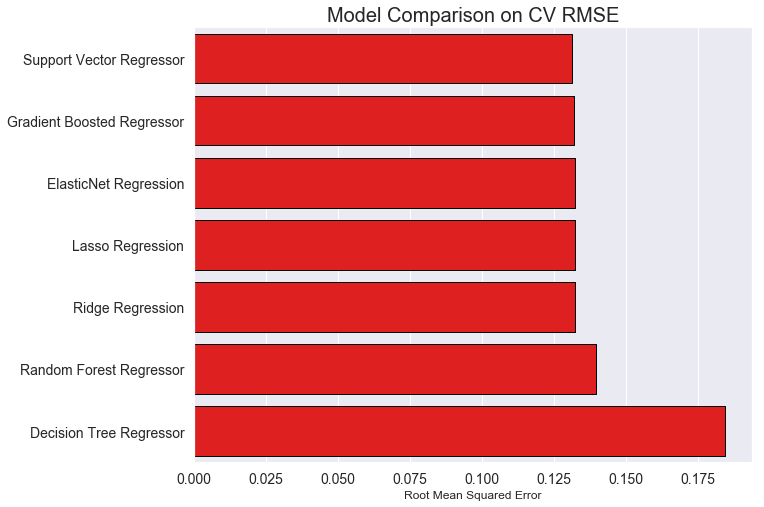

In [83]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Ridge Regression', 'Lasso Regression', 'ElasticNet Regression', 
                                           'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosted Regressor',
                                           'Support Vector Regressor'],
                                 'rmse': [rmse_cv_Ridge, rmse_cv_Lasso, rmse_cv_ElasticNet, rmse_cv_DecisionTree, 
                                         rmse_cv_RandomForest, rmse_cv_GB, rmse_cv_SVR]})

# Plot
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='rmse', y='model', data=model_comparison.sort_values('rmse', ascending = True), color='red', edgecolor='black')
plt.ylabel('')
plt.yticks(size = 14)
plt.xlabel('Root Mean Squared Error')
plt.xticks(size = 14)
plt.title('Model Comparison on CV RMSE', size = 20);

The Support Vector Regressor performs the best followed closely by the Gradient Boosted Regressor, ElasticNet, Lasso and Ridge Regresion. Especially with the Support Vector Regressor, the hyperparameters have a significant influence on performance. The Random Forest and Gradient Boosting methods are great for starting out because the performance is less dependent on the model settings.

From here, we will choose the best model but taking into account interpretability, so we could choose between Elastic, Lasso or Ridge Regressor since they seem to be accurate and are the most interpretable. We will choose Lasso Regressor. Since it only has one hyperparameter it is not necessary to perform a GridSearch for optimizing again (actually, we could have performed GridSearchCV before instead of RandomizedSearchCV). In the case we had chosen a model with more than one hyperparameter we should concentrate on optimizing the best model using GridSearchCV. Grid search evaluates every single combination we specify. As discussed above, random search is better when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options.

#### Model Interpretation

Let's take a look at how Lasso model picks the features:

Text(0.5, 1.0, 'Coefficients in Lasso Model')

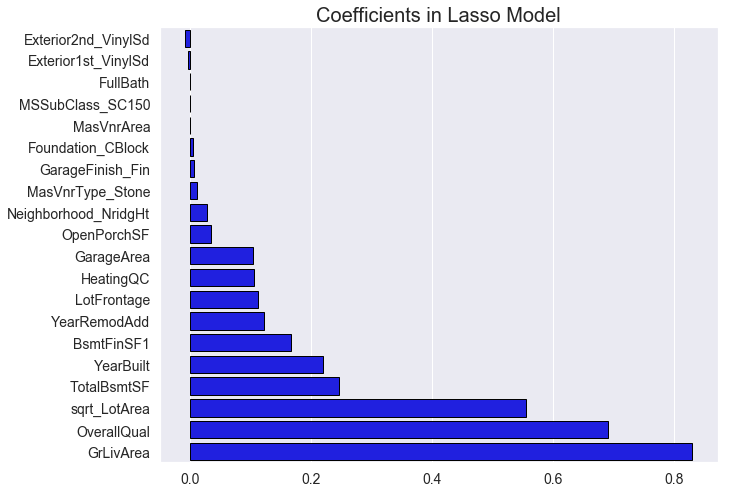

In [84]:
model_Lasso.fit(X_train,y_train)
coef = pd.Series(model_Lasso.coef_, index = X_train.columns)

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=imp_coef[:], y=imp_coef.index, color='blue', edgecolor='black')
plt.ylabel('')
plt.yticks(size = 14)
plt.xlabel('')
plt.xticks(size = 14)
plt.title('Coefficients in Lasso Model', size = 20)

In [85]:
print("Lasso picked " + str(sum(coef != 0)) + " features and eliminated the other " +  str(sum(coef == 0)) + " features")

Lasso picked 26 features and eliminated the other 3 features


As a reminder, Lasso Regression performs L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This type of regularization can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model. Larger penalties result in coefficient values closer to zero, which is the ideal for producing simpler models. On the other hand, L2 regularization (e.g. Ridge regression) doesn’t result in elimination of coefficients or sparse models. This makes the Lasso far easier to interpret than the Ridge.

So, having said that, our Lasso model has picked 26 features and eliminated the other 3 features, being the most important features the GrLivArea, OverallQual and sqrt_LotArea. It catchs my eye not to see the GarageCars, TotalBsmtSF or YearBuilt features with more importance for the model as they are highly correlated with SalePrice.

## SUBMISSION

In [86]:
submission_Lasso = pd.DataFrame()
submission_Lasso['Id'] = test_ID
model_Lasso.fit(X_train,y_train)
submission_Lasso['SalePrice'] = np.expm1(model_Lasso.predict(X_test))
submission_Lasso.to_csv('submission_Lasso.csv',index=False)

submission_Lasso.head()

,Id,SalePrice
0,1461,114402.576780
1,1462,150944.255345
2,1463,183385.822049
3,1464,199187.913999
4,1465,183597.885683


Kaggle score is 0.14516.

I must confess this is not a really good score but, since this is my first Kaggle competition the aim of this project wasn't be at the top of the leaderboard but learn and practice with a more realistic data science and machine learning problem and trust me I did!

For improving the results we could do more (and guess better) feature engineering, explore in deep the multilinearity of the problem and try ensemble models. Maybe apply some dimensionality reduction with Principal Component Analysis (PCA) may help as well. Anyway, I think this is a good step-by-step walkthrough of how a beginner data science and machine learning problem could be faced.

Hope you enjoy the reading and any suggestion is welcome!